In [3]:
import sys, os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
sys.path.append(os.path.abspath('../scripts'))
from ar_adasyn import ARADASYN
from alpha_distance_ar_adasyn import AlphaDistanceARADASYN

In [4]:
# Cargar dataset ecoli
ruta_ecoli = '../datasets/ecoli/ecoli.data'
df = pd.read_csv(ruta_ecoli, header=None, delim_whitespace=True)
X = df.iloc[:, 1:8].values
y = df.iloc[:, 8].values
y_bin = np.where(y == 'cp', 1, 0)
X_min = X[y_bin == 1]
X_maj = X[y_bin == 0]

from collections import Counter

print("Distribución binaria (y_bin):", Counter(y_bin))
print("Muestras clase minoritaria (X_min):", len(X_min))
print("Muestras clase mayoritaria (X_maj):", len(X_maj))

import numpy as np

print("Distribución de clases:", dict(enumerate(np.bincount(y_bin))))


Distribución binaria (y_bin): Counter({np.int64(0): 193, np.int64(1): 143})
Muestras clase minoritaria (X_min): 143
Muestras clase mayoritaria (X_maj): 193
Distribución de clases: {0: np.int64(193), 1: np.int64(143)}


C:\Users\User\AppData\Local\Temp\ipykernel_20796\3352879460.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ruta_ecoli, header=None, delim_whitespace=True)


In [8]:
# ==============================
# Comparar técnicas
# ==============================
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from alfa_dbasmote import AlphaDistanceDBASMOTE
from ar_adasyn import ARADASYN
from alpha_distance_ar_adasyn import AlphaDistanceARADASYN

from custom_samplers import AlphaDistanceDBASMOTEWrapper, ARADASYNWrapper, PCSMOTEWrapper

tecnicas = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
    "AR-ADASYN": ARADASYNWrapper(),  
    "AlphaDistanceARADASYN": AlphaDistanceARADASYN(m=5, beta=1.0, random_state=42),
    "AlphaDistanceDBASMOTE": AlphaDistanceDBASMOTEWrapper(beta=1.0, m=5, random_state=42),
    "PC-SMOTE": PCSMOTEWrapper(k_neighbors=5, random_state=42)
}



In [9]:
X = df.iloc[:, 1:8].values
y = df.iloc[:, 8].values
y_bin = np.where(y == 'cp', 1, 0)  # binarización

# Separar conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, stratify=y_bin, test_size=0.3, random_state=42)


In [12]:
for nombre, sampler in tecnicas.items():
    print(f"\n===== {nombre} =====")

    try:
        if nombre in ["SMOTE", "ADASYN", "BorderlineSMOTE", "PC-SMOTE"]:
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        else:
            X_min = X_train[y_train == 1]
            X_maj = X_train[y_train == 0]
            X_resampled, y_resampled = sampler.fit_resample(X_min, X_maj)

        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X_test)

        print(classification_report(y_test, y_pred, digits=4))

    except Exception as e:
        print(f"[ERROR] Falló {nombre}: {e}")



===== SMOTE =====
              precision    recall  f1-score   support

           0     1.0000    0.9310    0.9643        58
           1     0.9149    1.0000    0.9556        43

    accuracy                         0.9604       101
   macro avg     0.9574    0.9655    0.9599       101
weighted avg     0.9638    0.9604    0.9606       101


===== ADASYN =====
              precision    recall  f1-score   support

           0     0.9815    0.9138    0.9464        58
           1     0.8936    0.9767    0.9333        43

    accuracy                         0.9406       101
   macro avg     0.9375    0.9453    0.9399       101
weighted avg     0.9441    0.9406    0.9409       101


===== BorderlineSMOTE =====
              precision    recall  f1-score   support

           0     1.0000    0.9483    0.9735        58
           1     0.9348    1.0000    0.9663        43

    accuracy                         0.9703       101
   macro avg     0.9674    0.9741    0.9699       101
weight

In [13]:
# Cargar dataset ecoli
ruta_ecoli = '../datasets/ecoli/ecoli.data'
df = pd.read_csv(ruta_ecoli, header=None, delim_whitespace=True)
X = df.iloc[:, 1:8].values
y = df.iloc[:, 8].values

# Binarizar la clase
y_bin = np.where(y == 'cp', 1, 0)

# X_bin es solo un alias para claridad, ya que X no se modifica
X_bin = X


C:\Users\User\AppData\Local\Temp\ipykernel_20796\1523831882.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ruta_ecoli, header=None, delim_whitespace=True)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

resultados = {nombre: [] for nombre in tecnicas.keys()}
n_reps = 10

for seed in range(n_reps):
    print(f"\n>>> Iteración seed = {seed}")
    X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, stratify=y_bin, test_size=0.3, random_state=seed)

    for nombre, sampler in tecnicas.items():
        try:
            if nombre in ['SMOTE', 'ADASYN', 'BorderlineSMOTE','PC-SMOTE']:
                X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
            else:
                X_min = X_train[y_train == 1]
                X_maj = X_train[y_train == 0]
                X_resampled, y_resampled = sampler.fit_resample(X_min, X_maj)

            clf = RandomForestClassifier(random_state=seed)
            clf.fit(X_resampled, y_resampled)
            y_pred = clf.predict(X_test)
            f1 = f1_score(y_test, y_pred)
            resultados[nombre].append(f1)

        except Exception as e:
            print(f"[ERROR] Falló {nombre} con seed={seed}: {e}")
            resultados[nombre].append(np.nan)

# Mostrar promedios
df_resultados = pd.DataFrame({
    nombre: {
        'mean_f1': np.nanmean(valores),
        'std_f1': np.nanstd(valores)
    }
    for nombre, valores in resultados.items()
}).T.sort_values('mean_f1', ascending=False)

print("\n=== Promedio F1-score por técnica ===")
print(df_resultados)



>>> Iteración seed = 0

>>> Iteración seed = 1

>>> Iteración seed = 2

>>> Iteración seed = 3

>>> Iteración seed = 4

>>> Iteración seed = 5

>>> Iteración seed = 6

>>> Iteración seed = 7

>>> Iteración seed = 8

>>> Iteración seed = 9

=== Promedio F1-score por técnica ===
                        mean_f1    std_f1
AR-ADASYN              0.958254  0.021066
BorderlineSMOTE        0.955677  0.022497
AlphaDistanceARADASYN  0.952735  0.025533
AlphaDistanceDBASMOTE  0.950698  0.022857
PC-SMOTE               0.949606  0.023618
SMOTE                  0.948594  0.025326
ADASYN                 0.948131  0.023735


In [21]:
df_resultados.to_csv('../resultados/resultados_globales.csv', index=True)

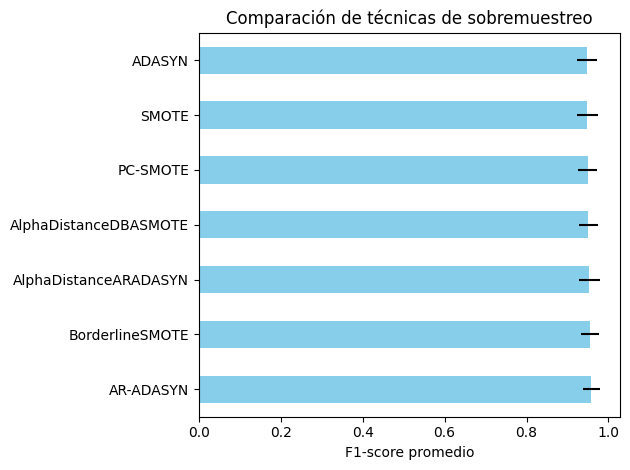

In [22]:
import matplotlib.pyplot as plt

df_resultados['mean_f1'].plot(kind='barh', xerr=df_resultados['std_f1'], color='skyblue')
plt.xlabel("F1-score promedio")
plt.title("Comparación de técnicas de sobremuestreo")
plt.tight_layout()
plt.show()

In [23]:
plt.tight_layout()
plt.savefig("../figures/comparacion_tecnicas_sobremuestreo.png")

<Figure size 640x480 with 0 Axes>